<a href="https://colab.research.google.com/github/monanjo123/Fraud-Detection/blob/master/Fraud%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import os
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import scipy
import seaborn as sns
import copy
from pandas import concat, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# unzip dataset zip file
local_zip = '/content/drive/My Drive/Machine Learning/datasets/ieee-fraud-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/My Drive/Machine Learning/datasets/iiee-fraud-detection')
zip_ref.close()

# Explore Data

In [0]:
data_path ='/content/drive/My Drive/Machine Learning/datasets/iiee-fraud-detection'
train_transaction = pd.read_csv('{}/train_transaction.csv'.format(data_path), low_memory=False)

In [0]:
# Reduce memory usage of data
def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train_transaction = reduce_mem_usage(train_transaction)

Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [6]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X_cols = train_transaction.columns[3:]
y_cols = 'isFraud'
temp_X = train_transaction[X_cols]
temp_y = train_transaction[y_cols]

# Get Categorical and Numerical Data
categorical_features = temp_X.dtypes==object
categorical = temp_X.columns[categorical_features].tolist()
numerical_features = ~categorical_features
numerical = temp_X.columns[numerical_features].tolist()
print(categorical)
print(numerical)


['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88

In [8]:
# We will only use the Categorical Data and some numerical data for this method
new_numerical = numerical[:9]
data_cols = categorical + new_numerical
correlation_cols = copy.copy(data_cols)
correlation_cols.append('isFraud')
cor_x = train_transaction[correlation_cols]
temp_X[data_cols].head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN


# Visualization

In [0]:
def plot_categorical(X,y, categorical_cols):
  for col in categorical_cols:
      if col in ['P_emaildomain',	'R_emaildomain']:
        continue
      plt.figure(figsize=(12,5))
      plot = sns.countplot(x = X[col], hue = y, data= X)
      plt.title("Data analysis {}".format(col))
      plot.set(xlabel='{} '.format(col), ylabel='Count')
      plt.show()
      
def plot_numerical(X,y, numerical_cols):
  for col in numerical_cols:
    if col in ['TransactionAmt']:
        continue
    plt.figure(figsize=(7,5))
    plot = sns.distplot(X[col], bins=len(X[col].unique()))
    plt.title("Data analysis {}".format(col))
    plot.set(xlabel='{} '.format(col), ylabel='Count')
    plt.show()
    
def plot_transactionAmt(X,y):
    plt.figure(figsize=(12,5))
    plot = sns.scatterplot(x=X['TransactionAmt'] , y=y, data= X)
    plt.title("Data analysis {}".format('TransactionAmt'))
    plot.set(xlabel='{} '.format('Amount'), ylabel='Fraud')
    plt.show()
    
def correlation_plot(data):
  plt.figure(figsize=(15,10))
  plt.title("Data Correlations")
  sns.heatmap(data.corr(), annot=True, fmt='g')
  plt.show()
  
def model_performance(model_name, y_test, Y_pred):
  plt.title('Model name: {}'.format(model_name))
  cm = metrics.confusion_matrix(y_test, Y_pred)
  sns.heatmap(cm, annot=True, fmt='g')
  plt.show()
  print('{} accuracy: {}%'.format(model_name, metrics.accuracy_score(y_test, y_pred) * 100))

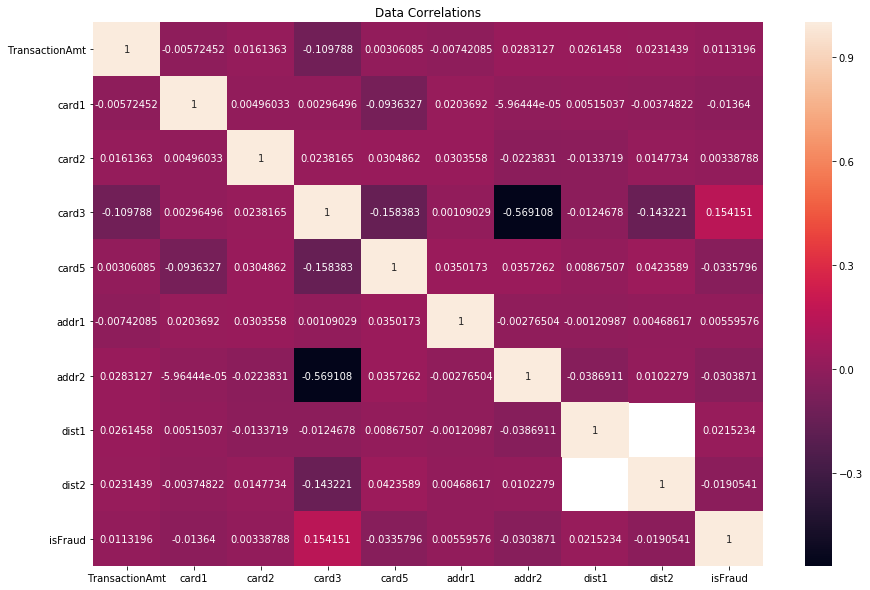

In [10]:
correlation_plot(cor_x)

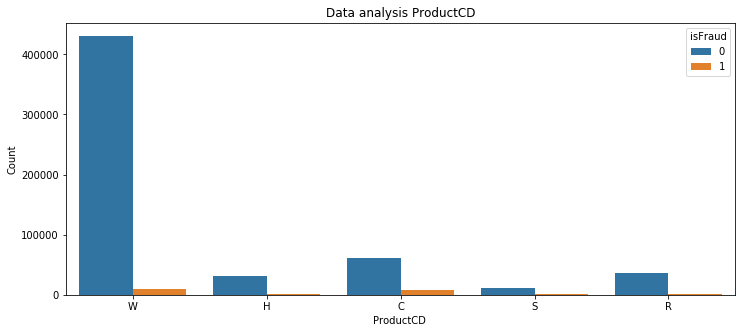

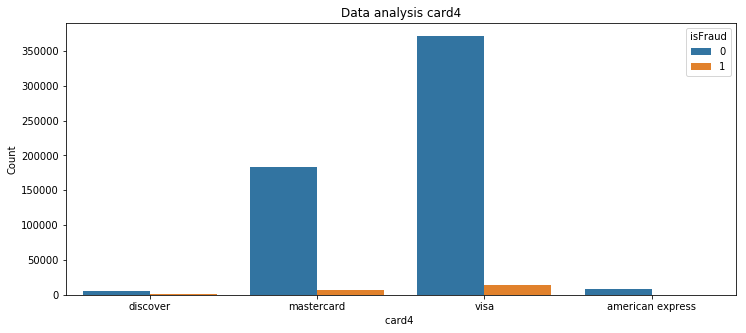

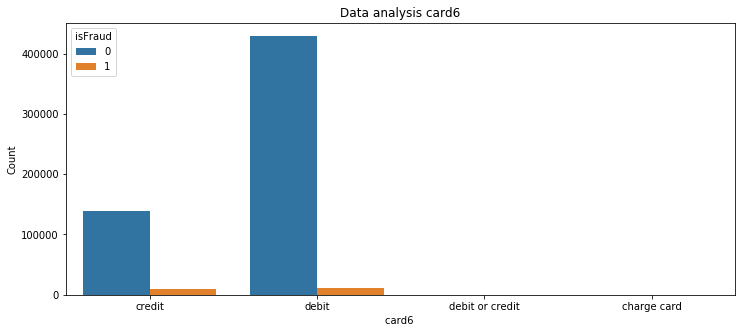

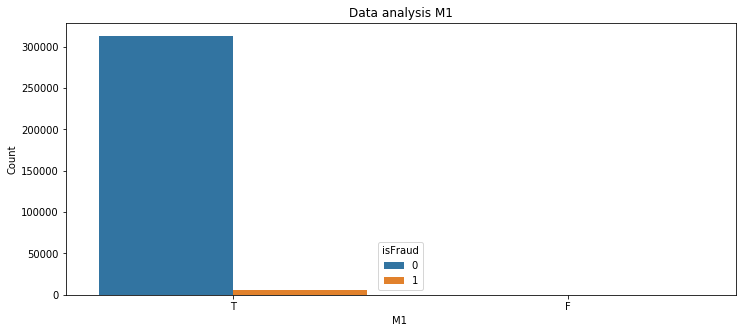

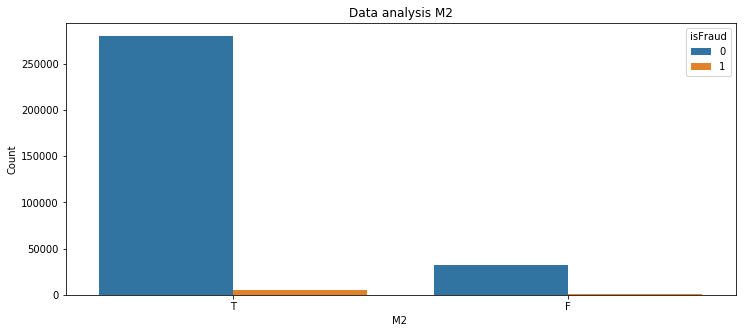

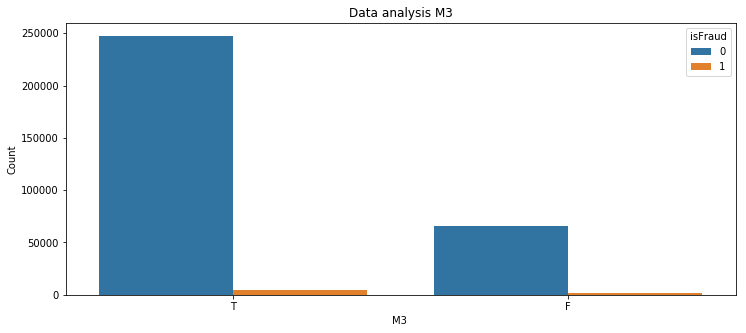

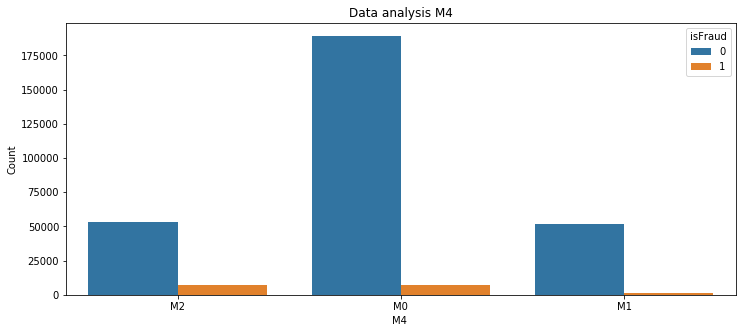

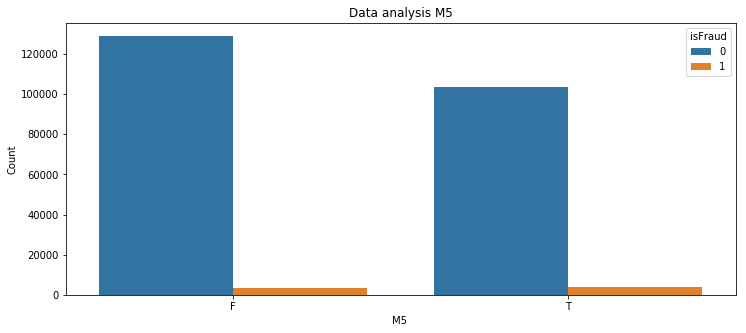

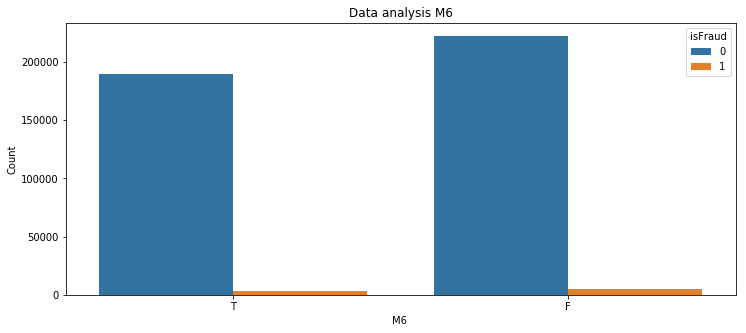

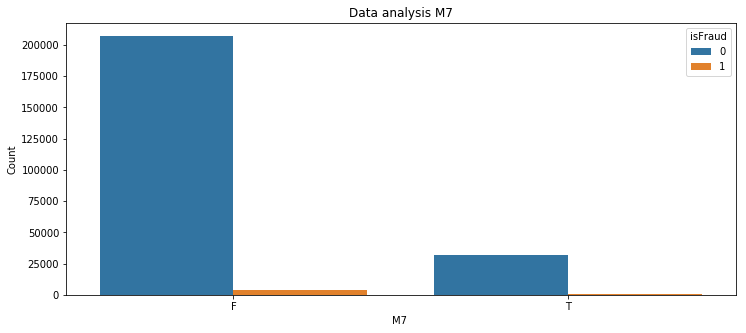

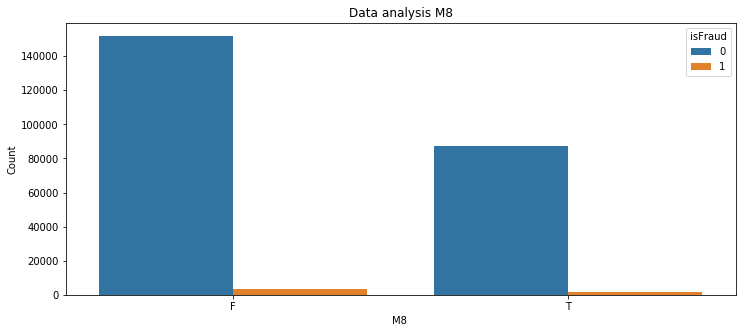

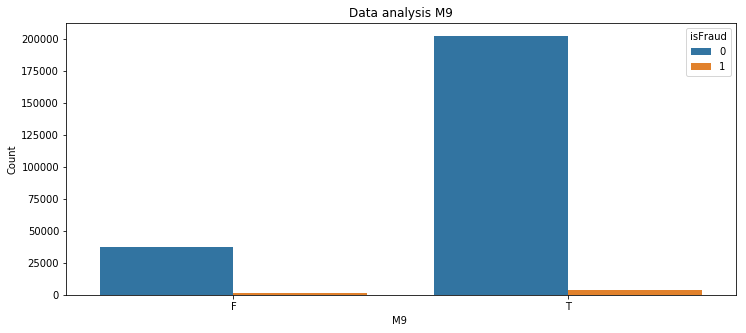

In [11]:
plot_categorical(temp_X[data_cols], temp_y, categorical)

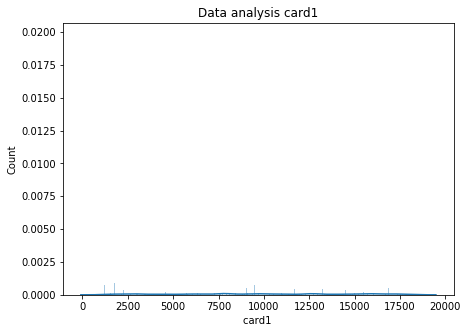

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


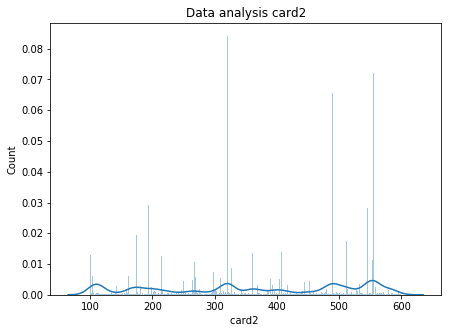

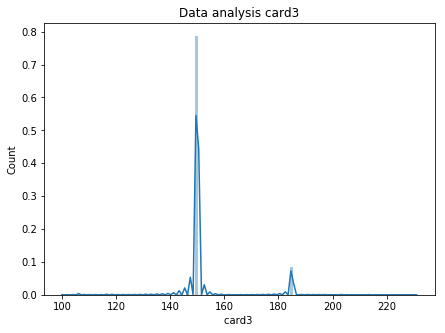

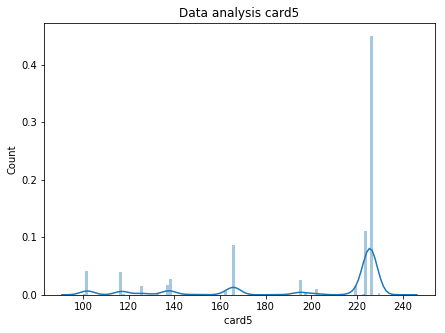

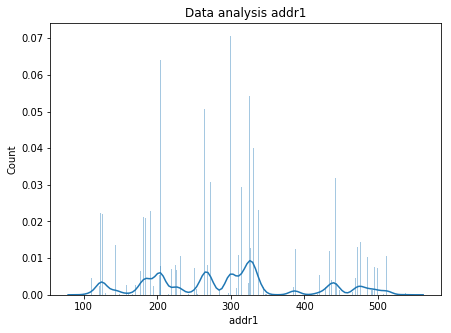

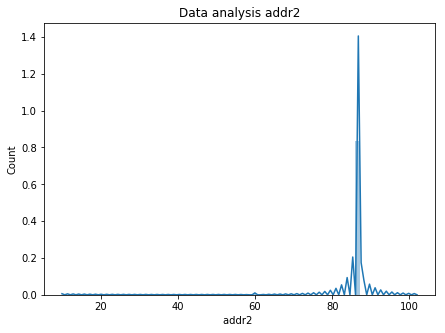

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


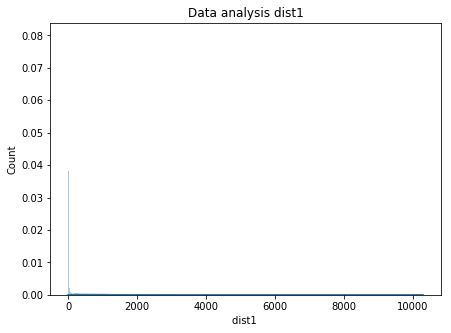

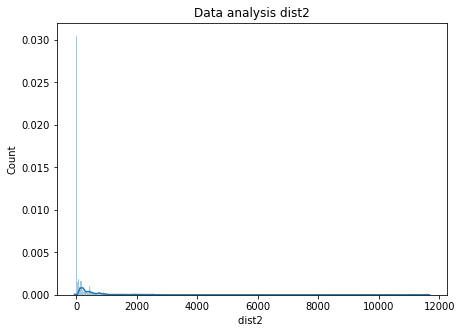

In [12]:
plot_numerical(temp_X[data_cols], temp_y, new_numerical)

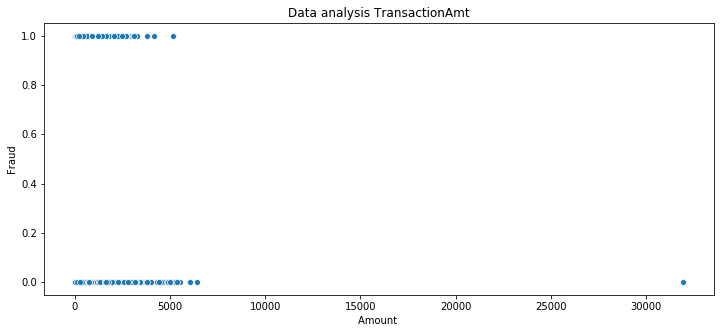

In [13]:
plot_transactionAmt(temp_X[data_cols], temp_y)

# Data Preprocessing

In [0]:
X = temp_X[data_cols]
y = temp_y.values

del temp_X,temp_y, train_transaction

In [0]:
# Get current Categorical and Numerical Data
categorical_features = X.dtypes==object
categorical = X.columns[categorical_features].tolist()
numerical_features = ~categorical_features
numerical = X.columns[numerical_features].tolist()

# Fill Missing Data
X[categorical] = X[categorical].fillna('NA')
X[numerical] = X[numerical].fillna(-1)

In [16]:
# Perform data normalization and one hot encoding for categorical data
preprocess = make_column_transformer(
    (numerical, StandardScaler()),
    (categorical, OneHotEncoder())
)
new_X = preprocess.fit_transform(X).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:778: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [17]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.33)
del new_X, X, y
print(X_train, y_train)

[[-0.26353937 -0.1827595  -0.35055113 ...  0.          1.
   0.        ]
 [-0.14646158 -1.26841953 -0.57173436 ...  0.          1.
   0.        ]
 [-0.48096955 -0.09155671  0.36829438 ...  0.          1.
   0.        ]
 ...
 [ 0.06260589 -1.18986679  0.54032579 ...  0.          1.
   0.        ]
 [ 3.31569585  0.46749393 -0.81134953 ...  0.          0.
   1.        ]
 [-0.20081913  1.11631912 -0.22152758 ...  0.          0.
   1.        ]] [0 0 0 ... 0 0 0]


# Logistic Regression

In [18]:
classifier_lr = LogisticRegression(random_state=0)
classifier_lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = classifier_lr.predict(X_test)

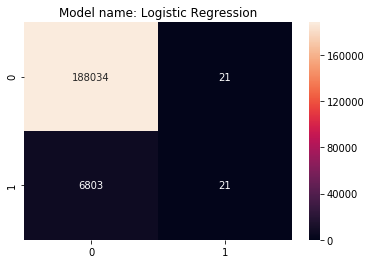

Logistic Regression accuracy: 96.498339995587%


In [29]:
model_performance('Logistic Regression', y_test, y_pred)

# Random Forest

In [21]:
classifier_rf = RandomForestClassifier(criterion='entropy', random_state=0)
classifier_rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

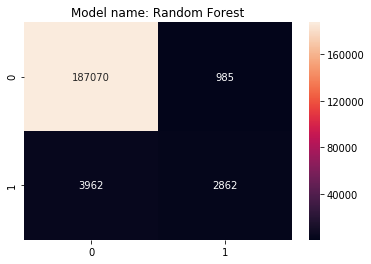

Random Forest accuracy: 96.498339995587%


In [30]:
y_pred_ref = classifier_rf.predict(X_test)
model_performance('Random Forest', y_test, y_pred_ref)

# Decision Tree Classifier

In [23]:
classifier_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

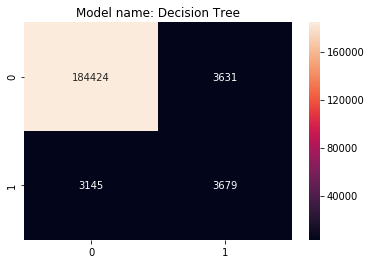

Decision Tree accuracy: 96.498339995587%


In [31]:
y_pred_tree = classifier_tree.predict(X_test)
model_performance('Decision Tree', y_test, y_pred_tree)